In [1]:
!nvidia-smi

Thu Jun  3 14:09:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  Off  | 00000000:81:00.0 Off |                  N/A |
| 23%   33C    P8     9W / 250W |  11694MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## Uncomment for installation on Colab
# !pip install --pre --index-url https://pypi.fury.io/tang/ --extra-index-url https://pypi.python.org/simple symfac

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import torch
import torch.nn.functional as F
from symfac.experimental import RBFExpansionMiniBatchPlus

torch.random.manual_seed(0)

# Load target image

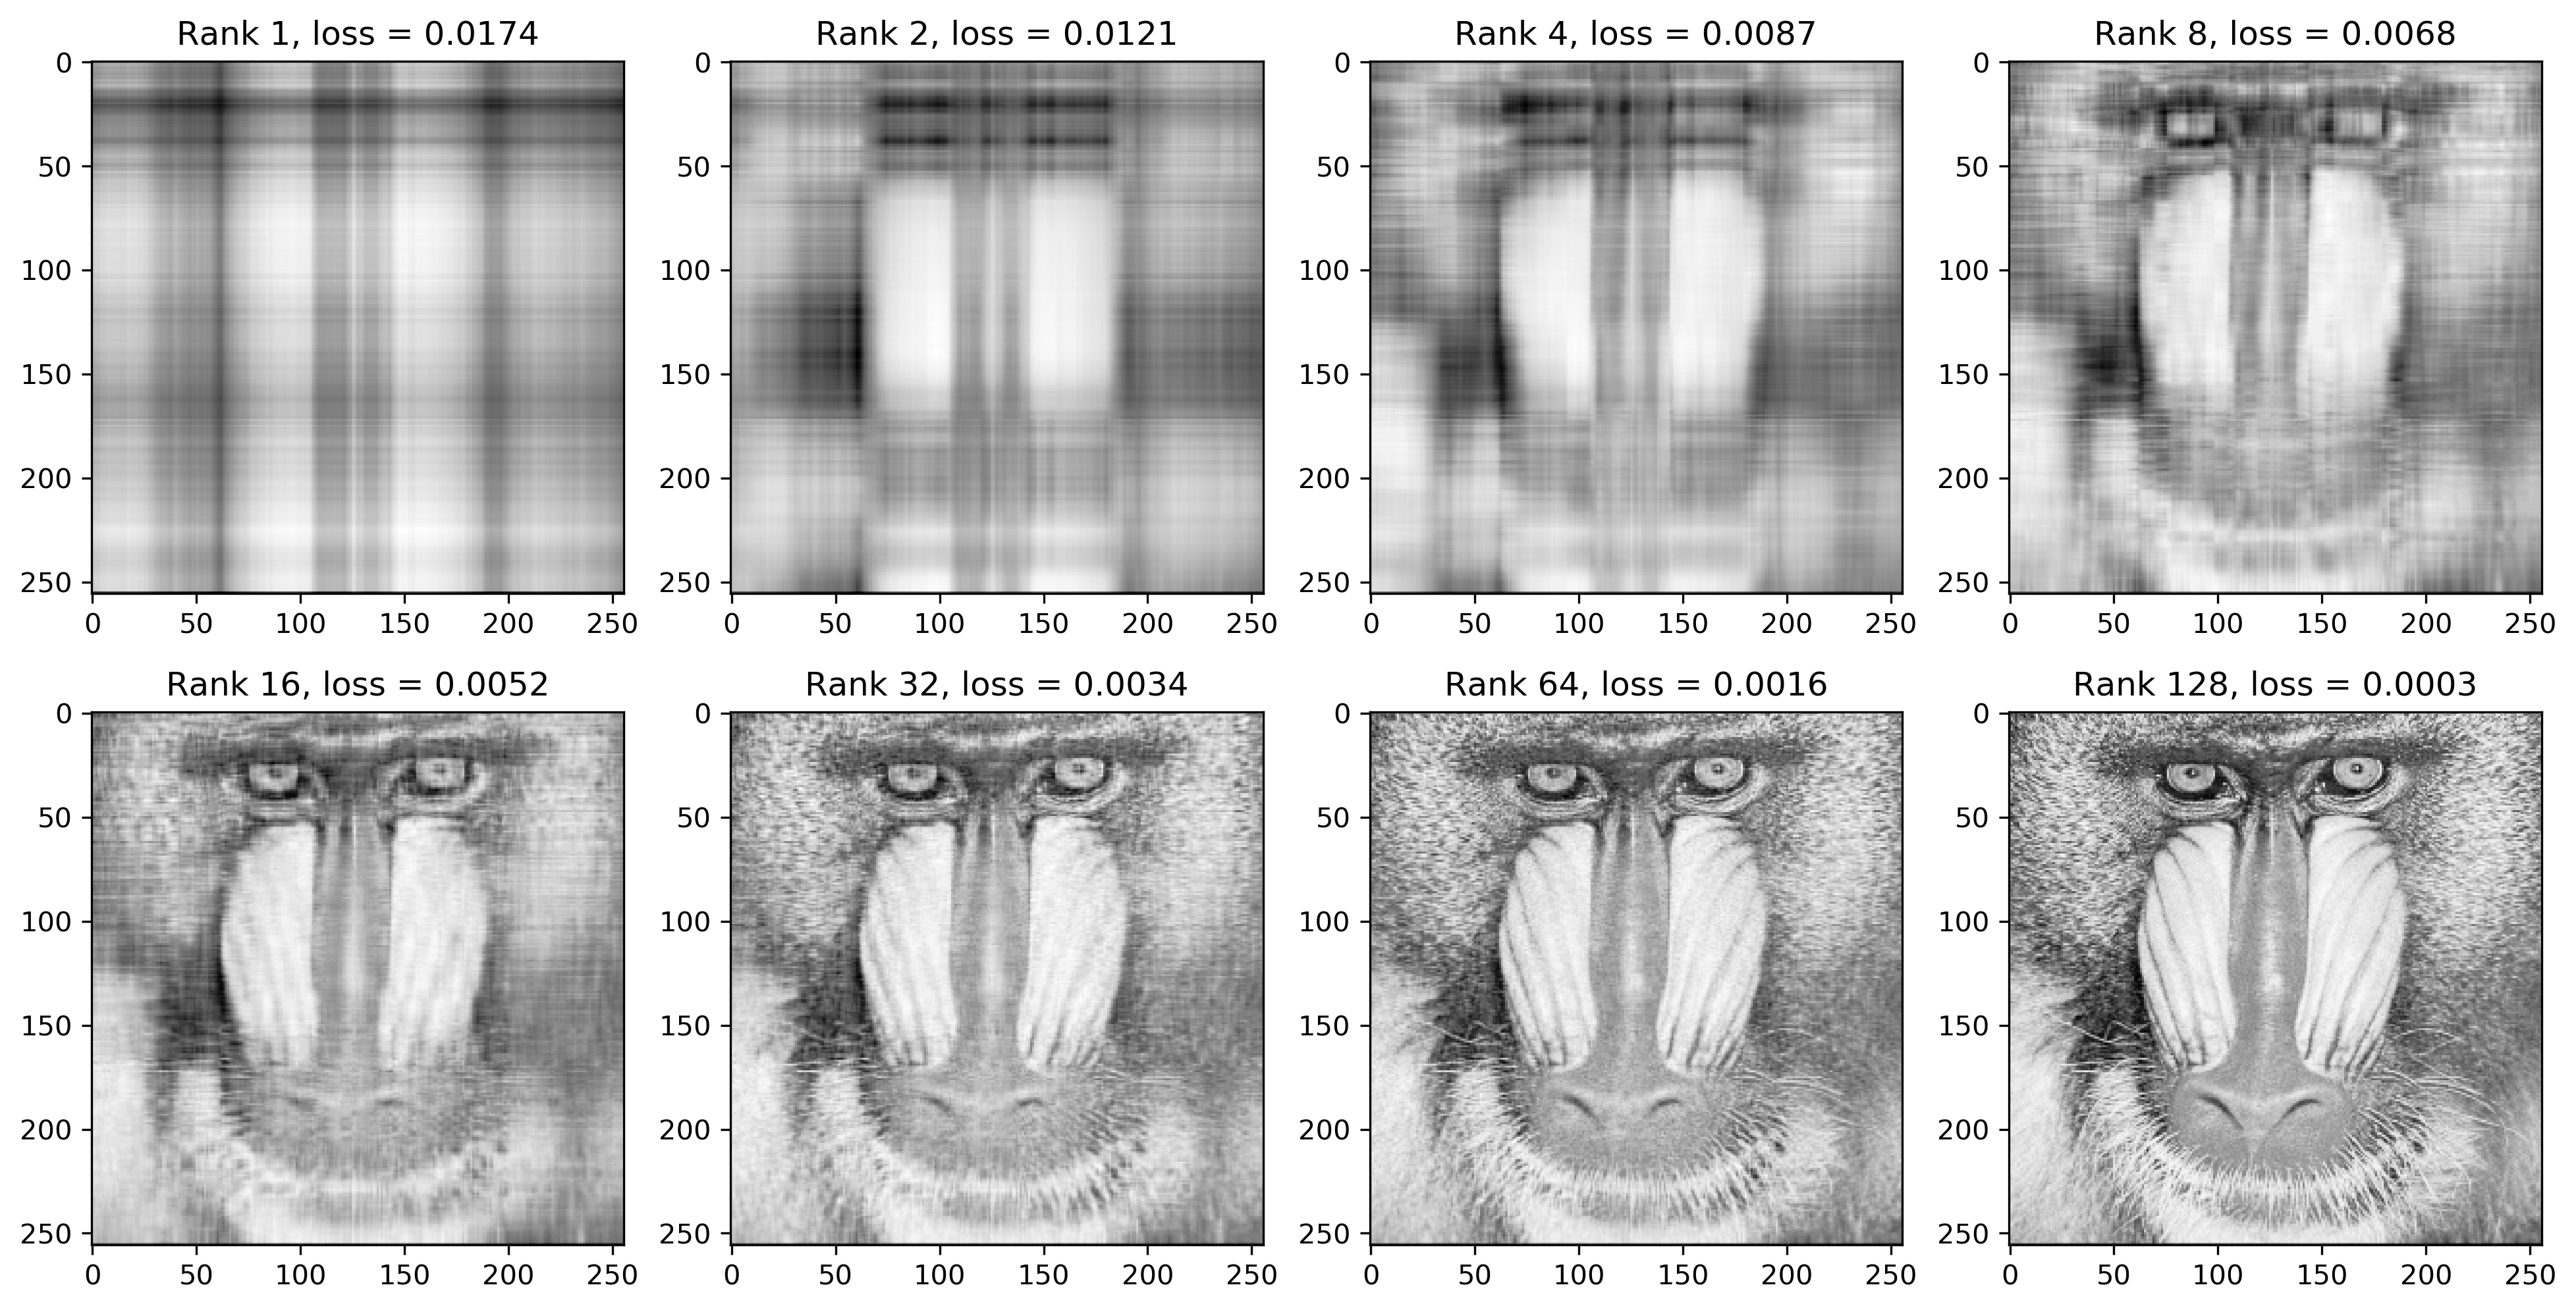

In [4]:
target = plt.imread('baboon-256x256.png')
# RBG to grayscale
target = target[:, :, 0] * 0.299 + target[:, :, 1] * 0.587 + target[:, :, 2] * 0.114
n, m = target.shape

U, S, V = np.linalg.svd(target)
fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=150)
for i, ax in enumerate(axs.ravel()):
    r = 2**i
    recon = (U[:, :r] * S[:r]) @ V[:r, :]
    ax.imshow(recon, cmap='Greys_r')
    ax.set_title(f'Rank {r}, loss = {F.mse_loss(torch.as_tensor(recon), torch.as_tensor(target)):.4f}')
plt.show()

# Fast SGD Pilot

In [5]:
factorizations = []

fac = RBFExpansionMiniBatchPlus(
    k=16,
    mini_batch_size=4 * 256,
    batch_size=32,
    max_steps=10000,
    mini_batch_by='elements'
)

fac.fit(
    target,
    u0=0.025 * fac.rand(fac.batch_size, n, fac.k),
    v0=0.025 * fac.rand(fac.batch_size, m, fac.k),
    a0=0.025 * fac.rand(fac.batch_size, fac.k),
    b0=0.025 * fac.rand(fac.batch_size)
)

RuntimeError: CUDA error: out of memory

In [ ]:
fig, axs = plt.subplots(8, 3, figsize=(18, 48))
for i, fac in enumerate(factorizations):
    r = 2**i
    best_run = torch.argmin(fac.report.loss_best)
    recon_rbf = fac.optimum(runs=best_run)
    recon_svd = (U[:, :r] * S[:r]) @ V[:r, :]
    axs[i, 0].imshow(recon_svd, cmap='Greys_r')
    axs[i, 1].imshow(recon_rbf, cmap='Greys_r')
    axs[i, 0].set_title(f'SVD Rank {r}, loss = {F.mse_loss(torch.as_tensor(recon_svd), torch.as_tensor(target)):.4f}')
    axs[i, 1].set_title(f'RBF Component {r}, loss = {F.mse_loss(torch.as_tensor(recon_rbf), torch.as_tensor(target)):.4f}')
    axs[i, 2].plot(fac.report.loss_history_ticks, fac.report.loss_history, lw=0.5, ls=(2,(3, 6)), dash_capstyle='round')
    axs[i, 2].plot(fac.report.loss_history_ticks, fac.report.loss_history.min(axis=1), lw=2, color='b', dash_capstyle='round', label='random-elements')
    for h, t in zip(fac.report.loss_history.T, fac.report.t_best):
        j = fac.report.loss_history_ticks.index(t)
        axs[i, 2].scatter(t, h[j], marker='+')
    axs[i, 2].set_title('SGD Training Loss')
    axs[i, 2].set_xlabel('Training steps')
    axs[i, 2].set_ylabel('Loss')
    axs[i, 2].set_xscale('log')
    axs[i, 2].set_yscale('log')
    axs[i, 2].legend(loc='upper right')
plt.show()

In [ ]:
factorizations = []

for i in range(8):
    fac = RBFExpansionMiniBatchPlus(
        k=2**i,
        mini_batch_size=4 * 256,
        batch_size=128,
        max_steps=20000,
        mini_batch_by='elements'
    )
    
    fac.fit(
        target,
        u0=0.025 * fac.rand(fac.batch_size, n, fac.k),
        v0=0.025 * fac.rand(fac.batch_size, m, fac.k),
        a0=0.025 * fac.rand(fac.batch_size, fac.k),
        b0=0.025 * fac.rand(fac.batch_size)
    )

    fac.to_pickle(f'data/baboon-{2**i:3d}-component-batch128.pickle')
    
    factorizations.append(fac)

In [ ]:
fig, axs = plt.subplots(8, 3, figsize=(18, 48))
for i, fac in enumerate(factorizations):
    r = 2**i
    best_run = torch.argmin(fac.report.loss_best)
    recon_rbf = fac.optimum(runs=best_run)
    recon_svd = (U[:, :r] * S[:r]) @ V[:r, :]
    axs[i, 0].imshow(recon_svd, cmap='Greys_r')
    axs[i, 1].imshow(recon_rbf, cmap='Greys_r')
    axs[i, 0].set_title(f'SVD Rank {r}, loss = {F.mse_loss(torch.as_tensor(recon_svd), torch.as_tensor(target)):.4f}')
    axs[i, 1].set_title(f'RBF Component {r}, loss = {F.mse_loss(torch.as_tensor(recon_rbf), torch.as_tensor(target)):.4f}')
    axs[i, 2].plot(fac.report.loss_history_ticks, fac.report.loss_history, lw=0.5, ls=(2,(3, 6)), dash_capstyle='round')
    axs[i, 2].plot(fac.report.loss_history_ticks, fac.report.loss_history.min(axis=1), lw=2, color='b', dash_capstyle='round', label='random-elements')
    for h, t in zip(fac.report.loss_history.T, fac.report.t_best):
        j = fac.report.loss_history_ticks.index(t)
        axs[i, 2].scatter(t, h[j], marker='+')
    axs[i, 2].set_title('SGD Training Loss')
    axs[i, 2].set_xlabel('Training steps')
    axs[i, 2].set_ylabel('Loss')
    axs[i, 2].set_xscale('log')
    axs[i, 2].set_yscale('log')
    axs[i, 2].legend(loc='upper right')
plt.show()

In [ ]:
factorizations = []

for i in range(8):
    fac = RBFExpansionMiniBatchPlus(
        k=2**i,
        mini_batch_size=8 * 256,
        batch_size=16,
        max_steps=100000,
        lr=0.025,
        mini_batch_by='elements'
    )
    
    fac.fit(
        target,
        u0=0.025 * fac.rand(fac.batch_size, n, fac.k),
        v0=0.025 * fac.rand(fac.batch_size, m, fac.k),
        a0=0.025 * fac.rand(fac.batch_size, fac.k),
        b0=0.025 * fac.rand(fac.batch_size)
    )

    fac.to_pickle(f'data/baboon-{2**i:3d}-component-lr0.025-step100000-mini8x.pickle')
    
    factorizations.append(fac)

In [ ]:
fig, axs = plt.subplots(8, 3, figsize=(18, 48))
for i, fac in enumerate(factorizations):
    r = 2**i
    best_run = torch.argmin(fac.report.loss_best)
    recon_rbf = fac.optimum(runs=best_run)
    recon_svd = (U[:, :r] * S[:r]) @ V[:r, :]
    axs[i, 0].imshow(recon_svd, cmap='Greys_r')
    axs[i, 1].imshow(recon_rbf, cmap='Greys_r')
    axs[i, 0].set_title(f'SVD Rank {r}, loss = {F.mse_loss(torch.as_tensor(recon_svd), torch.as_tensor(target)):.4f}')
    axs[i, 1].set_title(f'RBF Component {r}, loss = {F.mse_loss(torch.as_tensor(recon_rbf), torch.as_tensor(target)):.4f}')
    axs[i, 2].plot(fac.report.loss_history_ticks, fac.report.loss_history, lw=0.5, ls=(2,(3, 6)), dash_capstyle='round')
    axs[i, 2].plot(fac.report.loss_history_ticks, fac.report.loss_history.min(axis=1), lw=2, color='b', dash_capstyle='round', label='random-elements')
    for h, t in zip(fac.report.loss_history.T, fac.report.t_best):
        j = fac.report.loss_history_ticks.index(t)
        axs[i, 2].scatter(t, h[j], marker='+')
    axs[i, 2].set_title('SGD Training Loss')
    axs[i, 2].set_xlabel('Training steps')
    axs[i, 2].set_ylabel('Loss')
    axs[i, 2].set_xscale('log')
    axs[i, 2].set_yscale('log')
    axs[i, 2].legend(loc='upper right')
plt.show()

# Try non-negative component weights

In [ ]:
factorizations_nonneg = []

for i in range(8):
    fac = RBFExpansionMiniBatchPlus(
        k=2**i,
        mini_batch_size=4 * 256,
        batch_size=16,
        max_steps=10000,
        mini_batch_by='elements'
    )

    fac.fit_custom(
        target,
        f=lambda rbf, u, v, a, b: torch.mean(
            rbf(u[..., :, None, :] - v[..., None, :, :]) *
            torch.exp(a)[..., None, None, :],
            dim=-1
        ) + b[..., None, None],
        f_minibatch=lambda rbf, i, j, u, v, a, b: torch.mean(
            rbf(u[..., i, :] - v[..., j, :]) *
            torch.exp(a)[..., None, :],
            dim=-1
        ) + b[..., None],
        u=0.025 * fac.rand(fac.batch_size, n, fac.k),
        v=0.025 * fac.rand(fac.batch_size, m, fac.k),
        a=0.025 * fac.randn(fac.batch_size, fac.k),
        b=0.025 * fac.rand(fac.batch_size)
    )

    factorizations_nonneg.append(fac)

In [ ]:
fig, axs = plt.subplots(8, 3, figsize=(18, 48))
for i, fac in enumerate(factorizations_nonneg):
    r = 2**i
    best_run = torch.argmin(fac.report.loss_best)
    recon_rbf = fac.optimum(runs=best_run)
    recon_svd = (U[:, :r] * S[:r]) @ V[:r, :]
    axs[i, 0].imshow(recon_svd, cmap='Greys_r')
    axs[i, 1].imshow(recon_rbf, cmap='Greys_r')
    axs[i, 0].set_title(f'SVD Rank {r}, loss = {F.mse_loss(torch.as_tensor(recon_svd), torch.as_tensor(target)):.4f}')
    axs[i, 1].set_title(f'RBF Component {r}, loss = {F.mse_loss(torch.as_tensor(recon_rbf), torch.as_tensor(target)):.4f}')
    axs[i, 2].plot(fac.report.loss_history_ticks, fac.report.loss_history, lw=0.5, ls=(2,(3, 6)), dash_capstyle='round')
    axs[i, 2].plot(fac.report.loss_history_ticks, fac.report.loss_history.min(axis=1), lw=2, color='b', dash_capstyle='round', label='random-elements')
    for h, t in zip(fac.report.loss_history.T, fac.report.t_best):
        j = fac.report.loss_history_ticks.index(t)
        axs[i, 2].scatter(t, h[j], marker='+')
    axs[i, 2].set_title('SGD Training Loss')
    axs[i, 2].set_xlabel('Training steps')
    axs[i, 2].set_ylabel('Loss')
    axs[i, 2].set_xscale('log')
    axs[i, 2].set_yscale('log')
    axs[i, 2].legend(loc='upper right')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=150)
for i, (fac, ax) in enumerate(zip(factorizations_nonneg, axs.ravel())):
    r = 2**i
    best_run = torch.argmin(fac.report.loss_best)
    recon = fac.optimum(runs=best_run)
    ax.imshow(recon, cmap='Greys_r')
    ax.set_title(f'RBF Component {r}, loss = {F.mse_loss(torch.as_tensor(recon), torch.as_tensor(target)):.4f}')
plt.show()

END
---